# Stock Market Preadiction And Forecasting Using LSTM

## 1. We will collect the Stock Data- Axis Bank

In [1]:
import yfinance as yf

In [2]:
df=yf.download('AXISBANK.NS') #Download data from yfinance

[*********************100%***********************]  1 of 1 completed


In [3]:
import pandas_datareader as pdr

In [4]:
#yfinance is a financial data service that provides various financial data, including stock market data, news, and analysis.

In [5]:
df.to_csv('META.csv') #Save that file in csv mode 

In [6]:
import pandas as pd

In [7]:
df=pd.read_csv('META.csv')

In [8]:
df2=pd.read_csv('META.csv')

In [53]:
df2

,Date,Open,High,Low,Close,Adj Close,Volume
0,1998-11-27,3.550000,3.550000,2.710000,3.400000,2.255442,21000
1,1998-11-30,3.250000,3.300000,3.100000,3.210000,2.129403,132000
2,1998-12-01,3.290000,3.460000,3.220000,3.390000,2.248808,123500
3,1998-12-02,3.360000,3.440000,3.320000,3.390000,2.248808,75500
4,1998-12-03,3.440000,3.490000,3.370000,3.390000,2.248808,102000
...,...,...,...,...,...,...,...
6318,2024-03-01,1076.000000,1101.699951,1076.000000,1099.250000,1099.250000,4819390
6319,2024-03-04,1099.250000,1108.900024,1093.099976,1106.750000,1106.750000,5895441
6320,2024-03-05,1102.199951,1110.900024,1094.500000,1100.800049,1100.800049,4851446
6321,2024-03-06,1100.199951,1131.949951,1095.349976,1125.000000,1125.000000,13787638


In [10]:
df1=df.reset_index()['Close']

In [11]:
df1

0          3.400000
1          3.210000
2          3.390000
3          3.390000
4          3.390000
           ...     
6318    1099.250000
6319    1106.750000
6320    1100.800049
6321    1125.000000
6322    1111.449951
Name: Close, Length: 6323, dtype: float64

In [12]:
df1.shape

(6323,)

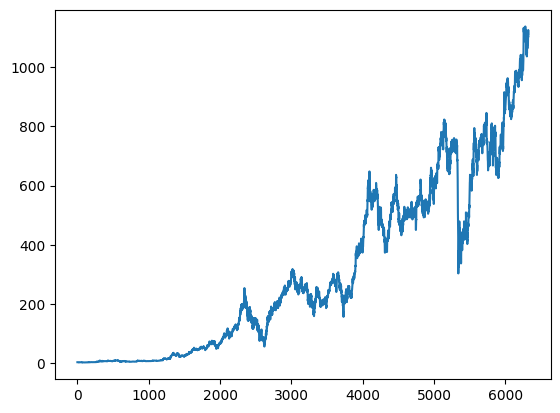

In [13]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [14]:
df1

0          3.400000
1          3.210000
2          3.390000
3          3.390000
4          3.390000
           ...     
6318    1099.250000
6319    1106.750000
6320    1100.800049
6321    1125.000000
6322    1111.449951
Name: Close, Length: 6323, dtype: float64

In [15]:
#LSTM are sensitive to scale of the data. So we apply MinMax scaler(to transform my value between 0 and 1)

In [16]:
import numpy as np

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
print(df1)

[[8.19758926e-04]
 [6.52281258e-04]
 [8.10944323e-04]
 ...
 [9.68135266e-01]
 [9.89466582e-01]
 [9.77522741e-01]]


In [19]:
df1.shape

(6323, 1)

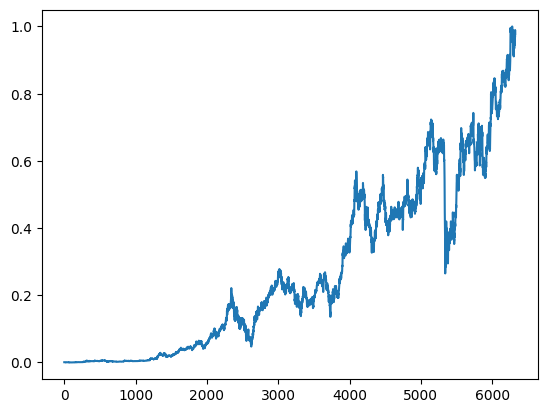

In [20]:
plt.plot(df1)

## 2. Preprocess the data - Train and Test

In [21]:
# Splitting dataset into train and test split(It's not normal way)
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [22]:
training_size,test_size

(4109, 2214)

In [23]:
len(train_data)

4109

In [24]:
import numpy as np
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]   ## for 0th ittration,i=0. 0,1,2,3,...,100 elements will be going into 1st record(if time_step=100)
        dataX.append(a)  # 101th element in go in X record
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [25]:
# reshape into x=t, t+1, t+2, t+3 and y=t+4
time_step=100
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)

In [26]:
print(x_train)

[[8.19758926e-04 6.52281258e-04 8.10944323e-04 ... 1.49848462e-04
  1.49848462e-04 1.14589840e-04]
 [6.52281258e-04 8.10944323e-04 8.10944323e-04 ... 1.49848462e-04
  1.14589840e-04 1.05775237e-04]
 [8.10944323e-04 8.10944323e-04 8.10944323e-04 ... 1.14589840e-04
  1.05775237e-04 1.49848462e-04]
 ...
 [3.44809966e-01 3.51817593e-01 3.66141337e-01 ... 5.12684226e-01
  5.00255645e-01 4.99021578e-01]
 [3.51817593e-01 3.66141337e-01 3.70724919e-01 ... 5.00255645e-01
  4.99021578e-01 5.09158381e-01]
 [3.66141337e-01 3.70724919e-01 3.71958986e-01 ... 4.99021578e-01
  5.09158381e-01 5.10172083e-01]]


In [27]:
x_train.shape

(4008, 100)

### 3.Create an Stacked LSTM Model

In [28]:
# reshape x_train,x_test from 2D to 3D [sample,time_step,feature] which is required for LSTM
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [29]:
# Create the Stacke LSTM model (stacke LSTM means one LSTM after the other )
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [31]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) # input_shape =(x_train.shape[1],1)
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
63/63 [==============================] - 23s 261ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 2/100
63/63 [==============================] - 15s 244ms/step - loss: 1.1964e-04 - val_loss: 0.0013
Epoch 3/100
63/63 [==============================] - 15s 236ms/step - loss: 1.1628e-04 - val_loss: 0.0015
Epoch 4/100
63/63 [==============================] - 15s 238ms/step - loss: 1.2643e-04 - val_loss: 0.0018
Epoch 5/100
63/63 [==============================] - 15s 237ms/step - loss: 1.0968e-04 - val_loss: 0.0012
Epoch 6/100
63/63 [==============================] - 15s 238ms/step - loss: 1.0288e-04 - val_loss: 0.0011
Epoch 7/100
63/63 [==============================] - 15s 236ms/step - loss: 9.7016e-05 - val_loss: 8.7828e-04
Epoch 8/100
63/63 [==============================] - 15s 237ms/step - loss: 9.9102e-05 - val_loss: 8.3808e-04
Epoch 9/100
63/63 [==============================] - 15s 234ms/step - loss: 9.2747e-05 - val_loss: 7.9315e-04
Epoch 10/100
63/63 [==================

### 4. Predict the test data and Plot the output

In [34]:
# Lets Do the prediction and check performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

67/67 [==============================] - 3s 46ms/step


In [35]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [36]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

176.9957192476698

In [37]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

672.6703638577832

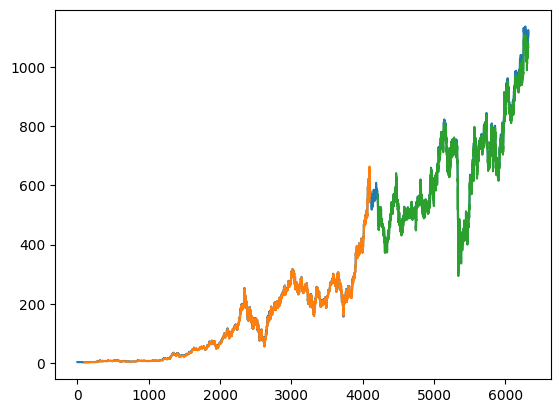

In [38]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### 5. Predict the future 30 days and plot the output 

In [39]:
len(test_data)

2214

In [40]:
x_input=test_data[2114:].reshape(1,-1)
x_input.shape

(1, 100)

In [41]:
x_input

array([[0.89554691, 0.87403923, 0.88351494, 0.88637969, 0.87298147,
        0.87170339, 0.86196321, 0.84781577, 0.84001486, 0.85464709,
        0.88170796, 0.86976417, 0.8632854 , 0.85442672, 0.86425504,
        0.86945563, 0.8875697 , 0.8977065 , 0.89841166, 0.89858796,
        0.90502256, 0.90162896, 0.91573234, 0.90251042, 0.87430366,
        0.86932344, 0.87205595, 0.87760914, 0.87844654, 0.88677636,
        0.89792686, 0.93230385, 0.94473243, 0.97152887, 0.98999544,
        0.99603342, 0.98550001, 0.98316411, 0.9949316 , 0.98197416,
        0.99475535, 0.98051973, 0.98545589, 0.98536777, 0.97743462,
        0.98527964, 0.97646503, 0.96337535, 0.957117  , 0.96236165,
        0.97302731, 0.9743495 , 0.96945746, 0.96540265, 0.96148019,
        0.96619599, 0.98805627, 1.        , 0.9868222 , 0.98201828,
        0.97360028, 0.99012768, 0.98536777, 0.98461855, 0.98426594,
        0.95182823, 0.9652264 , 0.98201828, 0.95795435, 0.93142239,
        0.91652567, 0.93327343, 0.92697097, 0.93

In [42]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [46]:
temp_input # 100 data

[0.8955469077744157,
 0.8740392342457002,
 0.8835149415855846,
 0.8863796903162474,
 0.872981470108201,
 0.8717033944838464,
 0.8619632057594981,
 0.8478157650957874,
 0.8400148554569533,
 0.8546470889919832,
 0.8817079569924211,
 0.869764169198451,
 0.8632853974813425,
 0.854426723705009,
 0.8642550370240996,
 0.8694556255166161,
 0.8875696951459785,
 0.8977064983467852,
 0.8984116565050785,
 0.8985879594946814,
 0.9050225613141812,
 0.9016289574148284,
 0.9157323357811681,
 0.9025104185627246,
 0.8743036618300454,
 0.8693234386245029,
 0.8720559466629336,
 0.8776091411346563,
 0.8784465399851813,
 0.8867763585928244,
 0.8979268636337592,
 0.9323038484017122,
 0.9447324290670015,
 0.9715288694830945,
 0.9899954374914254,
 0.996033424834467,
 0.9855000071572021,
 0.9831641135952296,
 0.9949315983995967,
 0.9819741625656172,
 0.9947553492101125,
 0.9805197301515408,
 0.9854558910597122,
 0.9853677664649702,
 0.977434616133904,
 0.9852796418702281,
 0.9764650303912658,
 0.963375353865054

In [47]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9360896]
101
1 day input [0.87403923 0.88351494 0.88637969 0.87298147 0.87170339 0.86196321
 0.84781577 0.84001486 0.85464709 0.88170796 0.86976417 0.8632854
 0.85442672 0.86425504 0.86945563 0.8875697  0.8977065  0.89841166
 0.89858796 0.90502256 0.90162896 0.91573234 0.90251042 0.87430366
 0.86932344 0.87205595 0.87760914 0.87844654 0.88677636 0.89792686
 0.93230385 0.94473243 0.97152887 0.98999544 0.99603342 0.98550001
 0.98316411 0.9949316  0.98197416 0.99475535 0.98051973 0.98545589
 0.98536777 0.97743462 0.98527964 0.97646503 0.96337535 0.957117
 0.96236165 0.97302731 0.9743495  0.96945746 0.96540265 0.96148019
 0.96619599 0.98805627 1.         0.9868222  0.98201828 0.97360028
 0.99012768 0.98536777 0.98461855 0.98426594 0.95182823 0.9652264
 0.98201828 0.95795435 0.93142239 0.91652567 0.93327343 0.92697097
 0.93900293 0.95354704 0.93838595 0.9334938  0.92340111 0.94019288
 0.91092842 0.92459106 0.92044813 0.94164732 0.96465343 0.94292539
 0.93988439 0.93477188 0.95738138 0.95

9 day output [[0.7858703]]
10 day input [0.88170796 0.86976417 0.8632854  0.85442672 0.86425504 0.86945563
 0.8875697  0.8977065  0.89841166 0.89858796 0.90502256 0.90162896
 0.91573234 0.90251042 0.87430366 0.86932344 0.87205595 0.87760914
 0.87844654 0.88677636 0.89792686 0.93230385 0.94473243 0.97152887
 0.98999544 0.99603342 0.98550001 0.98316411 0.9949316  0.98197416
 0.99475535 0.98051973 0.98545589 0.98536777 0.97743462 0.98527964
 0.97646503 0.96337535 0.957117   0.96236165 0.97302731 0.9743495
 0.96945746 0.96540265 0.96148019 0.96619599 0.98805627 1.
 0.9868222  0.98201828 0.97360028 0.99012768 0.98536777 0.98461855
 0.98426594 0.95182823 0.9652264  0.98201828 0.95795435 0.93142239
 0.91652567 0.93327343 0.92697097 0.93900293 0.95354704 0.93838595
 0.9334938  0.92340111 0.94019288 0.91092842 0.92459106 0.92044813
 0.94164732 0.96465343 0.94292539 0.93988439 0.93477188 0.95738138
 0.95350292 0.96822339 0.96460942 0.95438439 0.94896349 0.94468831
 0.94548165 0.96676896 0.973379

18 day output [[0.7201227]]
19 day input [0.89858796 0.90502256 0.90162896 0.91573234 0.90251042 0.87430366
 0.86932344 0.87205595 0.87760914 0.87844654 0.88677636 0.89792686
 0.93230385 0.94473243 0.97152887 0.98999544 0.99603342 0.98550001
 0.98316411 0.9949316  0.98197416 0.99475535 0.98051973 0.98545589
 0.98536777 0.97743462 0.98527964 0.97646503 0.96337535 0.957117
 0.96236165 0.97302731 0.9743495  0.96945746 0.96540265 0.96148019
 0.96619599 0.98805627 1.         0.9868222  0.98201828 0.97360028
 0.99012768 0.98536777 0.98461855 0.98426594 0.95182823 0.9652264
 0.98201828 0.95795435 0.93142239 0.91652567 0.93327343 0.92697097
 0.93900293 0.95354704 0.93838595 0.9334938  0.92340111 0.94019288
 0.91092842 0.92459106 0.92044813 0.94164732 0.96465343 0.94292539
 0.93988439 0.93477188 0.95738138 0.95350292 0.96822339 0.96460942
 0.95438439 0.94896349 0.94468831 0.94548165 0.96676896 0.97337992
 0.96813527 0.98946658 0.97752274 0.93608958 0.89760834 0.86930043
 0.85033602 0.83716977 0

26 day output [[0.6760559]]
27 day input [0.87760914 0.87844654 0.88677636 0.89792686 0.93230385 0.94473243
 0.97152887 0.98999544 0.99603342 0.98550001 0.98316411 0.9949316
 0.98197416 0.99475535 0.98051973 0.98545589 0.98536777 0.97743462
 0.98527964 0.97646503 0.96337535 0.957117   0.96236165 0.97302731
 0.9743495  0.96945746 0.96540265 0.96148019 0.96619599 0.98805627
 1.         0.9868222  0.98201828 0.97360028 0.99012768 0.98536777
 0.98461855 0.98426594 0.95182823 0.9652264  0.98201828 0.95795435
 0.93142239 0.91652567 0.93327343 0.92697097 0.93900293 0.95354704
 0.93838595 0.9334938  0.92340111 0.94019288 0.91092842 0.92459106
 0.92044813 0.94164732 0.96465343 0.94292539 0.93988439 0.93477188
 0.95738138 0.95350292 0.96822339 0.96460942 0.95438439 0.94896349
 0.94468831 0.94548165 0.96676896 0.97337992 0.96813527 0.98946658
 0.97752274 0.93608958 0.89760834 0.86930043 0.85033602 0.83716977
 0.82647914 0.81632388 0.80605972 0.79579443 0.78587031 0.7765587
 0.76795948 0.76002556 

In [48]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [49]:
import matplotlib.pyplot as plt

In [50]:
len(df1)

6323

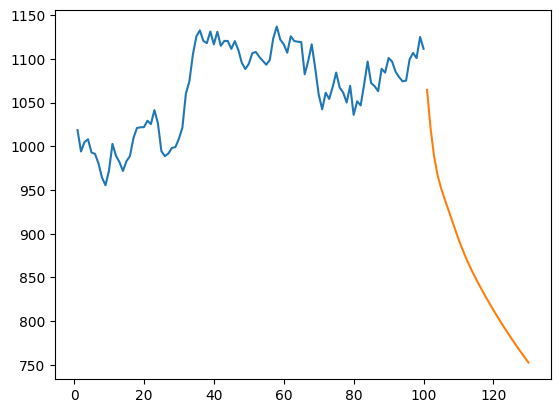

In [51]:

plt.plot(day_new,scaler.inverse_transform(df1[6223:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

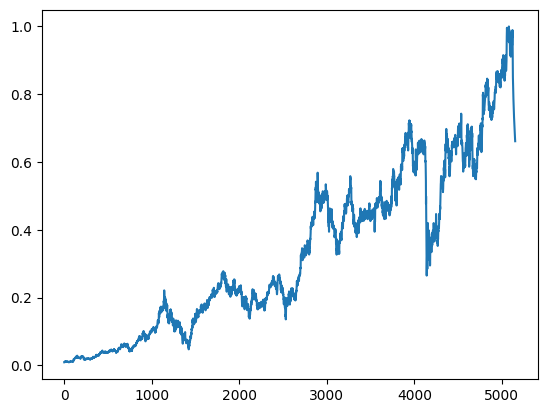

In [52]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
#end